In [2]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
df = pd.read_csv(url)
df

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,2020-03-11 17:00:00,ITA,9,Toscana,43.769231,11.255889,87,54,141,173,314,54,5,1,320,2804
353,2020-03-11 17:00:00,ITA,4,P.A. Trento,46.068935,11.121231,28,4,32,42,74,24,3,0,77,527
354,2020-03-11 17:00:00,ITA,10,Umbria,43.106758,12.388247,7,5,12,32,44,7,2,0,46,340
355,2020-03-11 17:00:00,ITA,2,Valle d'Aosta,45.737503,7.320149,2,0,2,17,19,2,0,1,20,99


In [56]:
FMT = '%Y-%m-%d %H:%M:%S'
date = df['data']
first_day = datetime.strptime(date[0], FMT)
# use as start day midnight to avoid error depending on the time of arrivale of each row
midnight = datetime.min.time()
first_day = datetime.combine(first_day, midnight)
df['days'] = date.map(lambda x : (datetime.combine(datetime.strptime(x, FMT), midnight) - first_day).days  )
df['data_simple'] = date.map(lambda x : datetime.strptime(x, FMT).strftime("%d-%m"))

In [54]:
codice_regioni = df.loc[:,['denominazione_regione','codice_regione']]
codice_regioni = codice_regioni.drop_duplicates().sort_values(by=['denominazione_regione'])
codice_regioni

,denominazione_regione,codice_regione
0,Abruzzo,13
1,Basilicata,17
3,Calabria,18
4,Campania,15
5,Emilia Romagna,8
342,Friuli V. G.,6
6,Friuli Venezia Giulia,6
7,Lazio,12
8,Liguria,7
9,Lombardia,3


In [55]:
last_day = max(df['days'])
max_count_df = df.loc[:, ['totale_casi','denominazione_regione', 'days', 'data_simple', 'data']]
max_count_df = max_count_df[df['days'] == last_day].sort_values(by=['days', 'totale_casi'], ascending=False)
max_count_df

,totale_casi,denominazione_regione,days,data_simple,data
345,7280,Lombardia,16,11-03,2020-03-11 17:00:00
341,1739,Emilia Romagna,16,11-03,2020-03-11 17:00:00
356,1023,Veneto,16,11-03,2020-03-11 17:00:00
348,501,Piemonte,16,11-03,2020-03-11 17:00:00
346,479,Marche,16,11-03,2020-03-11 17:00:00
352,320,Toscana,16,11-03,2020-03-11 17:00:00
344,194,Liguria,16,11-03,2020-03-11 17:00:00
340,154,Campania,16,11-03,2020-03-11 17:00:00
343,150,Lazio,16,11-03,2020-03-11 17:00:00
342,126,Friuli V. G.,16,11-03,2020-03-11 17:00:00


In [60]:
piemonte_df = df[df["codice_regione"] == 1]
lombardia_df = df[df["codice_regione"] == 3]
emiliar_df = df[df["codice_regione"] == 8]
veneto_df = df[df["codice_regione"] == 5]

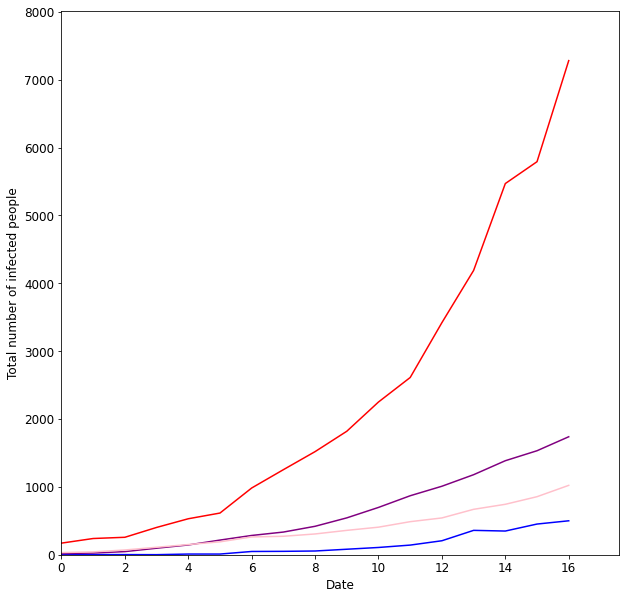

In [61]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('font', size=12)
plt.plot(list(piemonte_df['days']),list(piemonte_df['totale_casi']),label="Piemonte",color="blue")
plt.plot(list(lombardia_df['days']),list(lombardia_df['totale_casi']),label="Lombardia",color="red")
plt.plot(list(emiliar_df['days']),list(emiliar_df['totale_casi']),label="Emilia Romagna",color="purple")
plt.plot(list(veneto_df['days']),list(veneto_df['totale_casi']),label="Veneto",color="pink")


plt.xlabel("Date")
plt.ylabel("Total number of infected people")
plt.ylim((0,max(pd.concat([piemonte_df['totale_casi'], lombardia_df['totale_casi']]))*1.1))
plt.xlim((0*0.5,max(piemonte_df['days'])*1.1))

plt.show()